 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Projet Noté : OPTIMISATION </h2>
<h3> Professeur: Durantin Gautier</h3>
<h4> Étudiants: Bonnet Roman, Pages Hugo </h4>
</div>
    
    

### Objectifs du notebook
    
L’établissement du don du sang se demande quels sont les critères (parmi les 4 proposés) qui 
prédisent le mieux la tendance à donner son sang ou non, afin de mettre en place des règles métier 
pour recontacter certains anciens donneurs. On cherche à éviter d’utiliser des features deux à deux 
redondantes.
    
### Imports
    
Le notebook, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

In [ ]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.circuit.library import QAOAAnsatz

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error


from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Visualisation des données
## 1.1 Histogramme
On commence par représenter les données afin de mieux visualiser les differentes catégories. Afin d'observer les données nous affichons 4 histogrammes. 
- Haut gauche : 10 plus gros donneurs par frequences, classé du plus fréquent vers le moins fréquent.  
- Haut droite : 20 donneurs ayant donné le plus récemments , classé du plus récent vers le moins récent.
- Bas gauche  : 10 plus gros donneurs par quantité total de sang donné, classé du plus vers le moins.
- Bas droite  : 20 donneurs ayant donné leur sang pour la première fois depuis le plus longtemps.

remarque : les différentes catégories ayant de valeurs numeriques bien différentes nous utilisons une échelle logarithmique. 

In [ ]:
# 1. Chargement et préparation
data = pd.read_csv("transfusion.csv")
data.columns = [c.strip() for c in data.columns] # Nettoyage des noms
data['id Number'] = range(1, len(data) + 1)


name_categories = [
    'Frequency (times)', 
    'Recency (months)', 
    'Monetary (c.c. blood)', 
    'Time (months)'
]



In [ ]:



all_cols = name_categories + ['whether he/she donated blood in March 2007']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, cat in enumerate(name_categories):
    if cat == 'Recency (months)':
        # Pour Recency, on prend les 10 plus récents
        top_10 = data.nsmallest(20, cat).sort_values(cat, ascending=True)
    elif cat == 'Time (months)':
        top_10 = data.nlargest(20, cat).sort_values(cat, ascending=False)
    else:
        # Pour Monetary, on prend les 10 plus grands
        top_10 = data.nlargest(10, cat).sort_values(cat, ascending=False)


    plot_data = top_10.set_index('id Number')[all_cols]
    plot_data.plot(kind='bar', ax=axes[i], width=0.8, legend=(i == 0))
    axes[i].set_title(f"Top 10 basés sur : {cat}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("ID Donneur")
    axes[i].set_ylabel("Valeurs (Echelle Log)")
    axes[i].set_yscale('log') # Echelle log pour comparer Monetary aux autres
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)


plt.suptitle("Analyse comparative des Top 10 par catégorie", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## 1.2 Charactéristiques en fonction des donneurs 

In [ ]:
Freq=data['Frequency (times)'].to_numpy()
Rec=data['Recency (months)'].to_numpy()
Monet=data['Monetary (c.c. blood)'].to_numpy()
Time=data['Time (months)'].to_numpy()

Result=(data['whether he/she donated blood in March 2007']).to_numpy()
All_categories = [Freq, Rec, Monet, Time]

In [ ]:
#Chargement de toutes les colonnes


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()
colors=['red', 'green', 'blue', 'orange']
for i, cat in enumerate(All_categories): 
    axes[i].plot(cat, label=name_categories[i], color=colors[i])
    axes[i].set_title(f"{name_categories[i]}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("ID Donneur")
    axes[i].set_ylabel("Valeurs ") # Echelle log pour comparer Monetary aux autres
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)



# 2. Formulation du problème d'optimisation sous forme QUBO (Quadratic unconstrained binary optimization): 

Notre objectif est de trouver le set de catégories parmis les suivantes: 
-  Frequency : le nombre total de dons effectués par le donneur 
-  Recency : le nombre de mois écoulés depuis le dernier don du sang. 
-  Monetary : le volume total (en centimètres cubes) de sang donné 
-  Time : le nombre de mois écoulés depuis le premier don du sang

permettant de prevoir si au passage du camion en mars 2007 les donneurs ont donnés oui ou non leurs sang. On souhaite éliminer les informations deux à deux redondante. 

Afin d'appliquer le QAOA qui nécessitera un Hamiltonien, on cherche à se ramener à une forme QUBO de formulation du problème d'optimisation. Pour rappel, les problèmes QUBO sont formulés avec la fonction de cout suivante :

$$ C(X) = X^T Q X + c^T X $$

## 2.1. Construction de $X$ :  


Si on doit choisir parmi $n$ Categories, on note $X=[x_0,x_1,..,x_{n-1}]$ le vecteur décrivant si la catégories est prise en compte ou non. Les $x_i$ valent tous $0$ ou $1$, et représentent si la categorie est choisi ou pas.

Exemple : $X=[1,0,0,1]$ veut dire je prend en compte le frequence de don et le nombre de mois écoulés depuis le premier don du sang afin de savoir si un donneur va donner ou pas. 



## 2.2. Fonction à optimiser : 

Il est indiqué dans l'énoncé que nous souhaitons les caractèristiques qui prèdisent le mieux le don du sang en mars 2007 et éviter la redondance. Nous appelons $Y=[y_0,y_1,..,y_{n-1}]$ le vecteur binaire qui nous dis si oui ou non le donneur $i$ à donné son sang lors du passage du camion. 
Nous souhaitons donc maximiser la corrélation (ou l'information mutuelle) entre chaque categorie $i$ et la cible $Y$ tout en minimisant la redondance. 
La fonction d'optimisation peut donc s'écrire comme $$F(X) = \text{R}(X) - \text{P}(X)$$
avec $\text{R}$ : Redondance et $\text{P}$ : pertinance. 



## 2.3 Calcul de la redondance : 

On veut éviter de choisir deux variables trop similaires (ex: Frequency et Monetary sont souvent très corrélées).$$\text{R}(X) =  \sum_{i < j} Q_{ij} x_i x_j= X^T Q X $$, (Où $Q_{ij}$ est le coefficient de corrélation entre la feature $i$ et $j$ et $Q$ la matrice de correlation).

In [ ]:
Q=np.corrcoef(All_categories)


## 2.4 calcul de la pertinence

On veut maximiser la corrélation (ou l'information mutuelle) entre chaque feature $i$ et la cible $y$. En QUBO, on minimise, donc on utilise un signe négatif :$$\text{P}(X) = \sum_{i=1}^{4} c_i x_i = c^T X$$ (Où $Q_i$ est le score de corrélation de la feature $i$ avec le fait de redonner son sang et $c$ le vecteur composé des $c_i$).

In [ ]:
c=[np.corrcoef(cat,Result)[0][1] for cat in All_categories]
print(c)


## 2.5 Conclusion 
Nous avons desormais tout les paramètres pour formuler le problème sous la forme QUBO $$ C(X) = X^T Q X - c^T X $$  (Où $Q$ est la matrice de correlation entre les catégories et $c$ le vecteur de correlation entre une catégories et le résultat ). 


# 3. Brut force

In [ ]:

def get_criterion(x: np.ndarray, sigma: np.ndarray, mu : np.ndarray):
   return np.dot(x.T, np.dot(sigma, x)) - np.dot(mu, x)


I = np.identity(len(All_categories))
res=[]
for x in I:
   res.append(get_criterion(x,Q,c))
   print("Caracteristique ",x," :",res[-1])


i_min=np.argmin(res)
print(f"Le meilleur critère unique est : {I[i_min]} qui correspond à: {name_categories[i_min]}, la valeur du critère est {res[i_min]}" )

## 4. Derivation du Hamiltonien

In [ ]:
def get_operator(sigma: np.ndarray, mu : np.ndarray):
    num_nodes = len(mu)
    pauli_list = [] #contient la liste des matrices de Pauli à utiliser
    coeffs = [] #contient les coefficients associées à chaque matrice de Pauli

    #Termes en ZiZj
    for i in range(num_nodes):
        for j in range(i):
            if sigma[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(sigma[i,j]/4)

    #Termes en Zi
    for i in range(num_nodes):
            x_p = np.zeros(num_nodes, dtype=bool)
            z_p = np.zeros(num_nodes, dtype=bool)
            z_p[i] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(mu[i]/2-np.sum(sigma[i])/2)

    #shift = termes constants
    shift=np.sum(sigma)/4-np.sum(mu)/2
    pauli_list.append('IIII')
    coeffs.append(shift)

    return SparsePauliOp(pauli_list, coeffs=coeffs)

problem_operator = get_operator(Q,c)

## 5. QAOA

In [ ]:
r = 9

circuit=QAOAAnsatz(cost_operator=problem_operator, reps=r)
# circuit.decompose().draw('mpl')

In [ ]:
#paramètres initiaux arbitraires
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]*r

#ce vecteur contiendra les coûts mesurés à chaque étape
cost_vals=[]

In [ ]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    #Cette fonction estime le coût pour chaque configuration des paramètres, via le calcul de l'espérance mathématique du Hamiltonien.
    pass_manager = generate_preset_pass_manager(1, AerSimulator())
    isa_qc=pass_manager.run(ansatz.assign_parameters(params))
    pub = (isa_qc, hamiltonian)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    cost_vals.append(cost)
    return cost

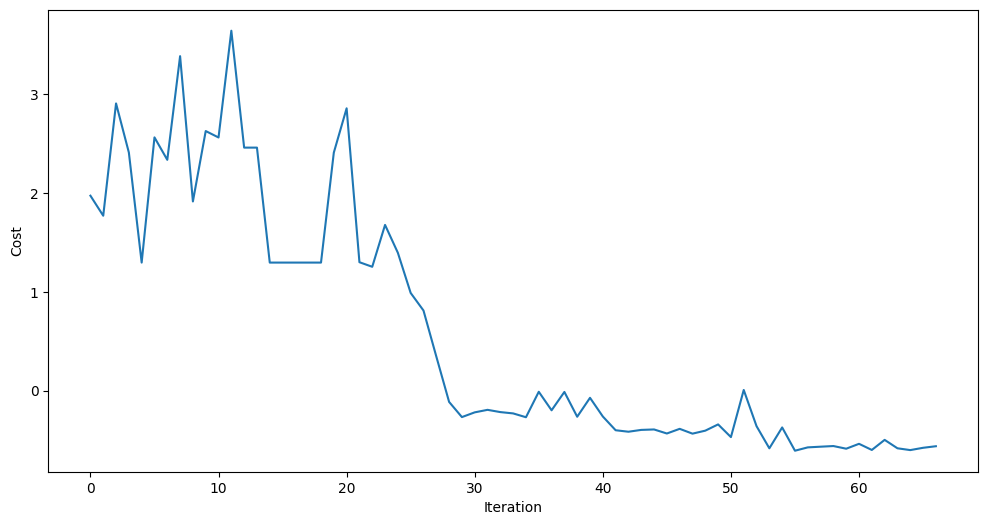

In [ ]:
estimator = Estimator()
estimator.options.default_shots = 1000
result = minimize(
        cost_func_estimator,
        init_params,
        args=(circuit, problem_operator, estimator),
        method="COBYLA",
        tol=1e-1,
    )
plt.figure(figsize=(12, 6))
plt.plot(cost_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
#Definition du circuit optimal pour le QAOA
optimal_parameters = result.x
optimal_qaoa_circuit=circuit.assign_parameters(optimal_parameters)
optimal_qaoa_circuit.measure_all()

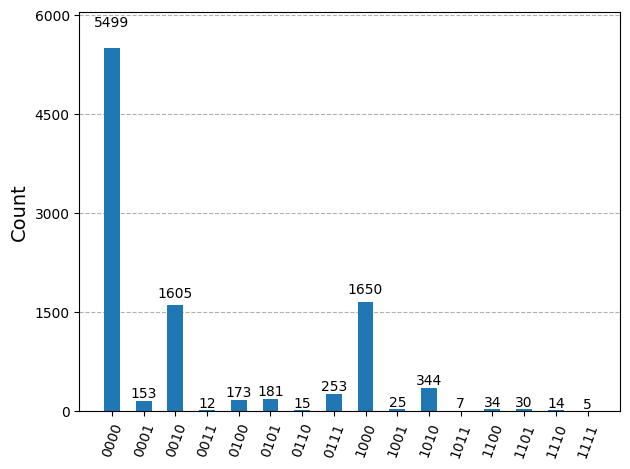

In [ ]:
pass_manager = generate_preset_pass_manager(1, AerSimulator())
sampler=Sampler()

isa_optimal_qaoa_circuit=pass_manager.run(optimal_qaoa_circuit)
job=sampler.run([isa_optimal_qaoa_circuit],shots=10000)
result=job.result()

counts=result[0].data.meas.get_counts()
#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())

## 6. Noisy simulation

In [ ]:
noise_model = NoiseModel()
prob_depolarisation = 0.05

noise_model.add_all_qubit_quantum_error(
    depolarizing_error(prob_depolarisation, num_qubits=1), ["x"]
)

noisy_sampler = Sampler(options=dict(backend_options=dict(noise_model=noise_model)))

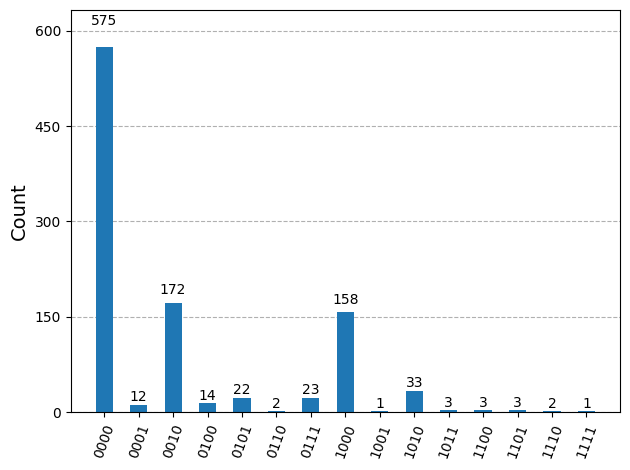

In [ ]:
job=noisy_sampler.run([isa_optimal_qaoa_circuit],shots=1024)
result=job.result()

counts=result[0].data.meas.get_counts()
#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())

## 7. Fake backend 

C:\Users\hugop\AppData\Local\Temp\ipykernel_16104\3423114041.py:7: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


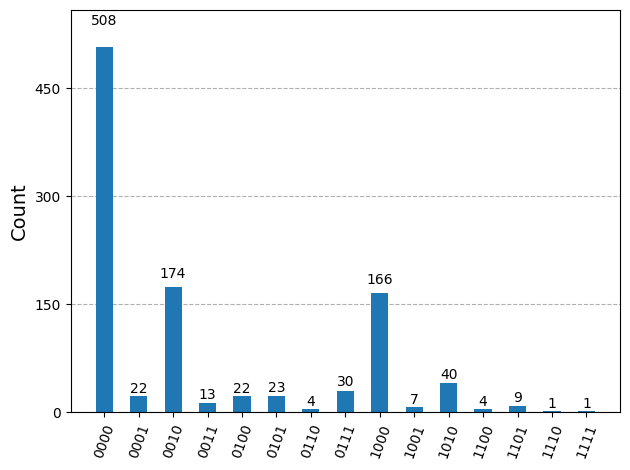

In [ ]:
import pickle
from qiskit_aer.noise import NoiseModel

with open('ibm_brisbane_eagle.mdl','rb') as f:
    real_noise_dict = pickle.load(f)

realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


#on execute la même expérience sur ce modele
realistic_sampler = Sampler(options=dict(backend_options=dict(noise_model=realistic_noise_model)))
job=realistic_sampler.run([isa_optimal_qaoa_circuit],shots=1024)
result=job.result()
#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())